## Testing out some code to hit the NHL API :)


Resources

* https://towardsdatascience.com/nhl-analytics-with-python-6390c5d3206d
* https://nhl-api-explorer.herokuapp.com/
* https://gitlab.com/dword4/nhlapi
* https://gitlab.com/dword4/nhlapi/-/blob/master/stats-api.md#game-ids
* https://github.com/dword4/nhlapi

Game IDs
* The first 4 digits identify the season of the game (ie. 2017 for the 2017-2018 season). 
* The next 2 digits give the type of game, where 01 = preseason, 02 = regular season, 03 = playoffs, 04 = all-star. 
* The final 4 digits identify the specific game number. 
* For regular season and preseason games, this ranges from 0001 to the number of games played. (1271 for seasons with 31 teams (2017 and onwards) and 1230 for seasons with 30 teams). 
* For playoff games, the 2nd digit of the specific number gives the round of the playoffs, the 3rd digit specifies the matchup, and the 4th digit specifies the game (out of 7).

In [1]:
# Load dependencies
import requests
import pandas as pd
import json
import os
import pathlib
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import RegularPolygon
color_map = plt.cm.winter
from PIL import Image
import math


In [2]:
# Set up the API call variables
year = '2020'
season_type = '02' 
max_game_id = 1271
boxscore_url = '/boxscore'
livefeed_url = '/feed/live'
game_url = 'http://statsapi.web.nhl.com/api/v1/game/'

In [57]:
# Test hitting the boxscore and live feed endpoints, save as JSON files
def request_get_data(url, 
                    year, 
                    season_type, 
                    max_game_id, 
                    endpoint,
                    empty_list = [],
                    zfill = 4, 
                    multiple_games = True):

    # If multiple_games param is true, the get data for n number of games (uses for loop)
    if multiple_games == True:    
        for i in range(1, max_game_id, 1):
            game_id = str(year) + str(season_type) + str(i).zfill(zfill)
            game_id_endpoint = str(url) + game_id + str(endpoint)
            r = requests.get(game_id_endpoint)
            data = r.json()
            data['game_id'] = game_id
            empty_list.append(data)

    # If multiple_games param is not true, then get data for the 1 game (no for loop)
    else:
        game_id = str(year) + str(season_type) + str(max_game_id).zfill(zfill)
        game_id_endpoint = str(url) +  game_id + str(endpoint)
        r = requests.get(game_id_endpoint)
        data = r.json()
        data['game_id'] = game_id
        empty_list.append(data)

    # Rename to game_data_json
    game_data_list = empty_list

    return game_data_list

# Function that takes in a list, converts to json, then saves a copy of that json file in the local folder
def save_as_json(list, 
                 file_name = 'data'):

    # Save as json file in same folder the notebook is run (relative)
    with open(f'{file_name}.json', 'w') as f:
        json.dump(list, f)

    # Convert list to json
    j_data = json.dumps(list)
 
    
    return j_data

In [58]:
# Create a folder to store the data
def mk_dir(rel_path = "test_data/"):
    try:
        #os.makedirs(path, exist_ok=True)
        pathlib.Path(rel_path).mkdir(parents=True, exist_ok=True) 

    except OSError:
        print ("Creation of the directory %s failed" % rel_path)
    else:
        print ("Successfully created the directory %s " % rel_path)

In [59]:
# Set inputs & prepare directory to story data
mk_dir(rel_path = "test_data/")
single_game_id = 100

# Boxscore
boxscore_list = request_get_data(game_url, 
                                year, 
                                season_type, 
                                single_game_id, 
                                boxscore_url,
                                multiple_games = True)

boxscore_json = save_as_json(boxscore_list, 'test_data/boxscore')

# Livefeed
livefeed_list = request_get_data(game_url, 
                                year, 
                                season_type, 
                                single_game_id, 
                                livefeed_url,
                                multiple_games = True)
livefeed_json = save_as_json(livefeed_list, 'test_data/livefeed')

Successfully created the directory test_data/ 


In [ ]:
# Uncomment the below code to print the game ids used to get each game
'''
max_game_id = 1290

#z_id = str(game_url) + str(year) + str(season_type) + str(max_game_id).zfill(4) + str(boxscore_url)
#for i in range(0, max_game_id, 1):
#    z_id = str(game_url) + str(year) + str(season_type) + str(i).zfill(4) + str(boxscore_url)
#    print(f'game: {i}, game_id: {z_id}')
'''

In [60]:
# Setup json object
json_object = json.loads(boxscore_json)

# Set up iterable variables
games = len(json_object)
#player_id = list(json_object[0]['teams']['home']['players'].keys())
raw = []

# Loop over every game
for game in range(0, (games), 1):
    game_id = json_object[game]["game_id"]

    # Loop over each home player in each team
    for player in list(json_object[game]['teams']['home']['players'].keys()):
        player_data = json_object[game]['teams']['home']['players'][player]['person']
        player_data ["home_team"] = 1
        player_data["pid"] = player
        player_data["game_id"] = game_id
        raw.append(player_data)

    # Loop over each away player in each team
    for player in list(json_object[game]['teams']['away']['players'].keys()):
        player_data = json_object[game]['teams']['away']['players'][player]['person']
        player_data ["home_team"] = 0
        player_data["pid"] = player
        player_data["game_id"] = game_id
        raw.append(player_data)

# Convert to pandas dataframe
df1 = pd.DataFrame.from_dict(raw)
df1 = df1.rename(columns={"id": "pid_num"})


# Flatten currentTeam
df2 = pd.concat([df1.drop(['currentTeam'], axis=1), df1['currentTeam'].apply(pd.Series)], axis=1)
df2 = df2.rename(columns={"id": "team_id", "name": "team_name", "link": "team_link"})

# Flatten primaryPosition
df2 = pd.concat([df2.drop(['primaryPosition'], axis=1), df2['primaryPosition'].apply(pd.Series)], axis=1)
df2 = df2.rename(columns={"code": "pos_code", "name": "pos_name", "type": "pos_type", "abbreviation": "pos_abbr"})

# Copy to player_stats
player_data = df2

# See the data
player_data.head(3)

,pid_num,fullName,team_link,firstName,lastName,primaryNumber,birthDate,currentAge,birthCity,birthCountry,...,pid,game_id,birthStateProvince,team_id,team_name,team_link,pos_code,pos_name,pos_type,pos_abbr
0,8480172,Jan Rutta,/api/v1/people/8480172,Jan,Rutta,44,1990-07-29,31,Pisek,CZE,...,ID8480172,2021020001,NaN,14,Tampa Bay Lightning,/api/v1/teams/14,D,Defenseman,Defenseman,D
1,8478519,Anthony Cirelli,/api/v1/people/8478519,Anthony,Cirelli,71,1997-07-15,24,Etobicoke,CAN,...,ID8478519,2021020001,ON,14,Tampa Bay Lightning,/api/v1/teams/14,C,Center,Forward,C
2,8478416,Erik Cernak,/api/v1/people/8478416,Erik,Cernak,81,1997-05-28,24,Kosice,SVK,...,ID8478416,2021020001,NaN,14,Tampa Bay Lightning,/api/v1/teams/14,D,Defenseman,Defenseman,D


In [ ]:
#df2.groupby('team_name').count()

In [61]:
# Setup json object
json_object = json.loads(boxscore_json)

# Set up iterable variables
games = len(json_object)
#player_id = list(json_object[0]['teams']['home']['players'].keys())
raw = []

# Loop over every game
for game in range(0, (games), 1):
    game_id = json_object[game]["game_id"]

    # Loop over each home player in each team
    for player in list(json_object[game]['teams']['home']['players'].keys()):
        player_stats = json_object[game]['teams']['home']['players'][player]['stats']
        player_stats ["home_team"] = 1
        player_stats["pid"] = player
        player_stats["game_id"] = game_id
        raw.append(player_stats)

    # Loop over each away player in each team
    for player in list(json_object[game]['teams']['away']['players'].keys()):
        player_stats = json_object[game]['teams']['away']['players'][player]['stats']
        player_stats ["home_team"] = 0
        player_stats["pid"] = player
        player_stats["game_id"] = game_id
        raw.append(player_stats)

# Convert to pandas dataframe
df1 = pd.DataFrame.from_dict(raw)
df1.head(3)

# Flatten the pandas dataframe
df1 = pd.json_normalize(raw, sep='_')

# Copy to player_stats
player_stats = df1

# Show first few rows
player_stats.head(3)

,home_team,pid,game_id,skaterStats_timeOnIce,skaterStats_assists,skaterStats_goals,skaterStats_shots,skaterStats_hits,skaterStats_powerPlayGoals,skaterStats_powerPlayAssists,...,goalieStats_shortHandedSaves,goalieStats_evenSaves,goalieStats_shortHandedShotsAgainst,goalieStats_evenShotsAgainst,goalieStats_powerPlayShotsAgainst,goalieStats_decision,goalieStats_savePercentage,goalieStats_evenStrengthSavePercentage,goalieStats_powerPlaySavePercentage,goalieStats_shortHandedSavePercentage
0,1,ID8480172,2021020001,15:55,0.0,0.0,3.0,0.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,ID8478519,2021020001,17:38,1.0,1.0,2.0,3.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1,ID8478416,2021020001,20:16,0.0,0.0,4.0,2.0,0.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [62]:
player_boxscore =  pd.merge(left = player_stats, 
                            right = player_data, 
                            how = 'left',
                            left_on = ['pid', 'game_id', 'home_team'],
                            right_on = ['pid', 'game_id', 'home_team'])

player_boxscore.head(3)

,home_team,pid,game_id,skaterStats_timeOnIce,skaterStats_assists,skaterStats_goals,skaterStats_shots,skaterStats_hits,skaterStats_powerPlayGoals,skaterStats_powerPlayAssists,...,shootsCatches,rosterStatus,birthStateProvince,team_id,team_name,team_link,pos_code,pos_name,pos_type,pos_abbr
0,1,ID8480172,2021020001,15:55,0.0,0.0,3.0,0.0,0.0,0.0,...,R,Y,NaN,14,Tampa Bay Lightning,/api/v1/teams/14,D,Defenseman,Defenseman,D
1,1,ID8478519,2021020001,17:38,1.0,1.0,2.0,3.0,0.0,0.0,...,L,Y,ON,14,Tampa Bay Lightning,/api/v1/teams/14,C,Center,Forward,C
2,1,ID8478416,2021020001,20:16,0.0,0.0,4.0,2.0,0.0,0.0,...,R,Y,NaN,14,Tampa Bay Lightning,/api/v1/teams/14,D,Defenseman,Defenseman,D


In [63]:
player_boxscore.columns

Index(['home_team', 'pid', 'game_id', 'skaterStats_timeOnIce',
       'skaterStats_assists', 'skaterStats_goals', 'skaterStats_shots',
       'skaterStats_hits', 'skaterStats_powerPlayGoals',
       'skaterStats_powerPlayAssists', 'skaterStats_penaltyMinutes',
       'skaterStats_faceOffWins', 'skaterStats_faceoffTaken',
       'skaterStats_takeaways', 'skaterStats_giveaways',
       'skaterStats_shortHandedGoals', 'skaterStats_shortHandedAssists',
       'skaterStats_blocked', 'skaterStats_plusMinus',
       'skaterStats_evenTimeOnIce', 'skaterStats_powerPlayTimeOnIce',
       'skaterStats_shortHandedTimeOnIce', 'skaterStats_faceOffPct',
       'goalieStats_timeOnIce', 'goalieStats_assists', 'goalieStats_goals',
       'goalieStats_pim', 'goalieStats_shots', 'goalieStats_saves',
       'goalieStats_powerPlaySaves', 'goalieStats_shortHandedSaves',
       'goalieStats_evenSaves', 'goalieStats_shortHandedShotsAgainst',
       'goalieStats_evenShotsAgainst', 'goalieStats_powerPlayShotsAga

In [64]:
mini_player_boxscore = player_boxscore[['pid', 'game_id','fullName', 'pos_type', 'pos_name', 'rookie', 'home_team', 'team_id',
       'team_name', 'skaterStats_timeOnIce',
       'skaterStats_assists', 'skaterStats_goals', 'skaterStats_shots',
       'skaterStats_hits', 'skaterStats_powerPlayGoals',
       'skaterStats_powerPlayAssists', 'skaterStats_penaltyMinutes',
       'skaterStats_faceOffWins', 'skaterStats_faceoffTaken',
       'skaterStats_takeaways', 'skaterStats_giveaways',
       'skaterStats_shortHandedGoals', 'skaterStats_shortHandedAssists',
       'skaterStats_blocked', 'skaterStats_plusMinus',
       'skaterStats_evenTimeOnIce', 'skaterStats_powerPlayTimeOnIce',
       'skaterStats_shortHandedTimeOnIce', 'skaterStats_faceOffPct']]

mini_player_boxscore.head(5)

,pid,game_id,fullName,pos_type,pos_name,rookie,home_team,team_id,team_name,skaterStats_timeOnIce,...,skaterStats_takeaways,skaterStats_giveaways,skaterStats_shortHandedGoals,skaterStats_shortHandedAssists,skaterStats_blocked,skaterStats_plusMinus,skaterStats_evenTimeOnIce,skaterStats_powerPlayTimeOnIce,skaterStats_shortHandedTimeOnIce,skaterStats_faceOffPct
0,ID8480172,2021020001,Jan Rutta,Defenseman,Defenseman,False,1,14,Tampa Bay Lightning,15:55,...,0.0,0.0,0.0,0.0,1.0,0.0,15:55,0:00,0:00,NaN
1,ID8478519,2021020001,Anthony Cirelli,Forward,Center,False,1,14,Tampa Bay Lightning,17:38,...,1.0,0.0,0.0,0.0,0.0,0.0,16:06,0:27,1:05,66.67
2,ID8478416,2021020001,Erik Cernak,Defenseman,Defenseman,False,1,14,Tampa Bay Lightning,20:16,...,0.0,0.0,0.0,0.0,0.0,-1.0,19:37,0:00,0:39,NaN
3,ID8474567,2021020001,Zach Bogosian,Defenseman,Defenseman,False,1,14,Tampa Bay Lightning,14:14,...,0.0,1.0,0.0,0.0,0.0,-2.0,14:14,0:00,0:00,NaN
4,ID8470621,2021020001,Corey Perry,Forward,Right Wing,False,1,14,Tampa Bay Lightning,12:40,...,0.0,0.0,0.0,0.0,1.0,-2.0,12:13,0:27,0:00,NaN


Fiddling with the livefeed api...

In [65]:
# Setup json object
json_object = json.loads(livefeed_json)

# Set up iterable variables
games = len(json_object)
#player_id = list(json_object[0]['teams']['home']['players'].keys())
raw = []

# Loop over every game
for game in range(0, (games), 1):
    game_id = json_object[game]["game_id"]

    # Loop over each home player in each team
    for player in list(json_object[game]['teams']['home']['players'].keys()):
        player_data = json_object[game]['teams']['home']['players'][player]['person']
        player_data["home_team"] = 1
        player_data["pid"] = player
        player_data["game_id"] = game_id
        raw.append(player_data)

    # Loop over each away player in each team
    for player in list(json_object[game]['teams']['away']['players'].keys()):
        player_data = json_object[game]['teams']['away']['players'][player]['person']
        player_data["home_team"] = 0
        player_data["pid"] = player
        player_data["game_id"] = game_id
        raw.append(player_data)

# Convert to pandas dataframe
df1 = pd.DataFrame.from_dict(raw)
df1 = df1.rename(columns={"id": "pid_num"})


# Flatten currentTeam
df2 = pd.concat([df1.drop(['currentTeam'], axis=1), df1['currentTeam'].apply(pd.Series)], axis=1)
df2 = df2.rename(columns={"id": "team_id", "name": "team_name", "link": "team_link"})

# Flatten primaryPosition
df2 = pd.concat([df2.drop(['primaryPosition'], axis=1), df2['primaryPosition'].apply(pd.Series)], axis=1)
df2 = df2.rename(columns={"code": "pos_code", "name": "pos_name", "type": "pos_type", "abbreviation": "pos_abbr"})

# Copy to player_stats
player_data = df2

# See the data
player_data.head(3)

KeyError: 'teams'

In [9]:
json_object = json.loads(livefeed_json)

# Set up iterable variables
games = len(json_object)

games

66

In [10]:
# For each play resulting in a shot or goal, get the player name, event type, and the x y coordinates of the shot
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

# Setup json object
json_object = json.loads(livefeed_json)

# Set up iterable objects
games = len(json_object)
event_types = ['Shot','Goal']
raw_d = {"game_id":[], "player_id":[], "player_type":[], "x_coord":[], "y_coord":[], "play_id":[], "event":[], "event_type":[]}

# Loop over every game
for game in json_object:

    # Look for live data - if it doesnt exist, go to next game
    if 'liveData' not in game:
        continue
    
    # If it does exist, drill down into liveData>plays>allPlays
    plays = game['liveData']['plays']['allPlays']
    # Store the game_id
    game_id = game['gamePk']

    # There so many PLAYS... we want to loop through each play...
    for play in plays:
        
        #.. and search for the EVENTS we defined earlier (Shot & Goal)
        for event in event_types:

            # If the play contains one of the events...
            if play['result']['event'] in ['Shot']:
                # ... and if the event contains coordinates...
                        if 'x' in play['coordinates']:
                            # Save the coordinates to the growing list
                            raw_d["game_id"].append(game_id)
                            raw_d["player_id"].append(play['players'][0]['player']['id'])
                            raw_d["x_coord"].append(play['coordinates']['x'])
                            raw_d["y_coord"].append(play['coordinates']['y'])
                            raw_d["player_type"].append(play['players'][0]['player']['fullName'])
                            raw_d["play_id"].append(play['about']['player']['fullName'])
                            raw_d["event"].append(play['players'][0]['player']['fullName'])
                            raw_d["event_type"].append(play['players'][0]['player']['fullName'])

    

# Convert to pandas dataframe
df1 = pd.DataFrame.from_dict(raw_d)

df1.head(5)

KeyError: 'player'

In [11]:
# For each play resulting in a shot or goal, get the player name, event type, and the x y coordinates of the shot
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

# Setup json object
json_object = json.loads(livefeed_json)

# Set up iterable objects
games = len(json_object)
event_types = ['Shot','Goal']
raw_d = {
        "game_id":[], 
        "player_id":[], 
        "player_name":[], 
        "player_type":[], 
        "play_id": [],
        "x_coord":[], 
        "y_coord":[], 
        "event":[],
        "event_type":[],
        "event_desc": [],
        "period": [],
        "period_time": []

        }

# Loop over every game
for game in json_object:

    # Look for live data - if it doesnt exist, go to next game
    if 'liveData' not in game:
        continue
    
    # If it does exist, drill down into liveData>plays>allPlays
    plays = game['liveData']['plays']['allPlays']
    # Store the game_id
    game_id = game['gamePk']

     # There so many PLAYS... we want to loop through each play...
    for play in plays:
        if 'players' in play:
            for player in play['players']:
                if player['playerType'] in ["Shooter", "Scorer"]:
                    player_type = player['playerType']
                    player_id = player['player']['id']
                    player_name = player['player']['fullName']

                #.. and search for the EVENTS we defined earlier (Shot & Goal)
                for event in event_types:

                    # If the play contains one of the events...
                    if play['result']['event'] in event_types:
                        # ... and if the event contains coordinates...
                                if 'x' in play['coordinates']:
                                    # Save the coordinates to the growing list
                                    raw_d["game_id"].append(game_id)
                                    raw_d["player_id"].append(player_id)
                                    raw_d["x_coord"].append(play['coordinates']['x'])
                                    raw_d["y_coord"].append(play['coordinates']['y'])
                                    raw_d["player_name"].append(player_name)
                                    raw_d["player_type"].append(player_type)
                                    raw_d["event"].append(play['result']['event'])
                                    raw_d["event_type"].append(play['result']['secondaryType'])
                                    raw_d["event_desc"].append(play['result']['description'])
                                    raw_d["period"].append(play['about']['period'])
                                    raw_d["period_time"].append(play['about']['periodTime'])
                                    raw_d["play_id"].append(play['about']['eventIdx'])


# This loop causes duplication (x4), not sure where...

# Convert to pandas dataframe
df1 = pd.DataFrame.from_dict(raw_d)

# Drop dups
df2 = df1.drop_duplicates()

# Add some features
df2['goal'] = np.where(df2['event']== 'Goal', 1, 0)
df2['league'] = 'NHL'

# See data
df2.head(5)

,game_id,player_id,player_name,player_type,play_id,x_coord,y_coord,event,event_type,event_desc,period,period_time,goal,league
0,2021020001,8474564,Steven Stamkos,Shooter,8,61.0,-32.0,Shot,Wrist Shot,Steven Stamkos Wrist Shot saved by Tristan Jarry,1,01:03,0,NHL
4,2021020001,8476934,Brock McGinn,Shooter,13,-65.0,19.0,Shot,Wrist Shot,Brock McGinn Wrist Shot saved by Andrei Vasile...,1,01:44,0,NHL
8,2021020001,8480172,Jan Rutta,Shooter,15,-8.0,-27.0,Shot,Wrist Shot,Jan Rutta Wrist Shot saved by Tristan Jarry,1,02:01,0,NHL
12,2021020001,8478046,Danton Heinen,Shooter,19,-60.0,-4.0,Shot,Wrist Shot,Danton Heinen Wrist Shot saved by Andrei Vasil...,1,02:47,0,NHL
16,2021020001,8476292,Ondrej Palat,Shooter,22,63.0,4.0,Shot,Wrist Shot,Ondrej Palat Wrist Shot saved by Tristan Jarry,1,03:07,0,NHL


In [12]:
# For each play resulting in a shot or goal, get the player name, event type, and the x y coordinates of the shot
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

def get_shot_goal_data(livefeed_json):

    # Setup json object
    json_object = json.loads(livefeed_json)

    # Set up iterable objects
    games = len(json_object)
    event_types = ['Shot','Goal']
    raw_d = {
            "game_id":[], 
            "player_id":[], 
            "play_id":[], 
            "player_name":[], 
            "player_type":[], 
            "play": [],
            "x_coord":[], 
            "y_coord":[], 
            "event":[],
            "event_type":[],
            "event_desc": [],
            "period": [],
            "period_time": []

            }

    # Loop over every game
    for game in json_object:

        # Look for live data - if it doesnt exist, go to next game
        if 'liveData' not in game:
            continue
        
        # If it does exist, drill down into liveData>plays>allPlays
        plays = game['liveData']['plays']['allPlays']
        # Store the game_id
        game_id = game['gamePk']

        # There so many PLAYS... we want to loop through each play...
        for play in plays:
            if 'players' in play:
                for player in play['players']:
                    if player['playerType'] in ["Shooter", "Scorer"]:
                        player_type = player['playerType']
                        player_id = player['player']['id']
                        player_name = player['player']['fullName']

                    #.. and search for the EVENTS we defined earlier (Shot & Goal)
                    for event in event_types:
                        # If the play contains one of the events...
                        if play['result']['event'] in [event]:
                            # ... and if the event contains coordinates...
                                    if 'x' in play['coordinates']:
                                        # Save the coordinates to d2 
                                        raw_d["game_id"].append(game_id)
                                        raw_d["player_id"].append(player_id)
                                        raw_d["x_coord"].append(play['coordinates']['x'])
                                        raw_d["y_coord"].append(play['coordinates']['y'])
                                        raw_d["player_name"].append(player_name)
                                        raw_d["player_type"].append(player_type)
                                        raw_d["play"].append(play['coordinates'])
                                        raw_d["event"].append(play['result']['event'])
                                        raw_d["event_type"].append(play['result']['secondaryType'])
                                        raw_d["event_desc"].append(play['result']['description'])
                                        raw_d["period"].append(play['about']['period'])
                                        raw_d["period_time"].append(play['about']['periodTime'])
                                        raw_d["play_id"].append(play['about']['eventIdx'])


    # This loop causes duplication (x4), not sure where...

    # Convert to pandas dataframe
    df1 = pd.DataFrame.from_dict(raw_d)

    # Drop dups
    #df2 = df1.drop_duplicates()

    # Add some features
    #df2['goal'] = np.where(df2['event']== 'Goal', 1, 0)
    #df2['league'] = 'NHL'

    # See data
    return raw_d, df1#, df2


In [13]:
raw_d, df_dup = get_shot_goal_data(livefeed_json)

df_dup.head(3)

,game_id,player_id,play_id,player_name,player_type,play,x_coord,y_coord,event,event_type,event_desc,period,period_time
0,2021020001,8474564,8,Steven Stamkos,Shooter,"{'x': 61.0, 'y': -32.0}",61.0,-32.0,Shot,Wrist Shot,Steven Stamkos Wrist Shot saved by Tristan Jarry,1,01:03
1,2021020001,8474564,8,Steven Stamkos,Shooter,"{'x': 61.0, 'y': -32.0}",61.0,-32.0,Shot,Wrist Shot,Steven Stamkos Wrist Shot saved by Tristan Jarry,1,01:03
2,2021020001,8476934,13,Brock McGinn,Shooter,"{'x': -65.0, 'y': 19.0}",-65.0,19.0,Shot,Wrist Shot,Brock McGinn Wrist Shot saved by Andrei Vasile...,1,01:44


## Analyzing shots & goals

In [15]:
# Get player summaries
player_shots = df2.groupby(['player_name', 'player_id', 'league']).agg({'goal':['count', 'sum']})
player_shots.columns = ["_".join(x) for x in player_shots.columns.ravel()]
player_shots = player_shots.rename(columns = {"goal_count": "sog", "goal_sum": "goals"})
player_shots = player_shots.reset_index()
player_shots['conversion'] = round(player_shots['goals'] / player_shots['sog'], 4)

# Get league summaries
league_shots = df2.groupby('league').agg({'goal':['count', 'sum']})
league_shots.columns = ["_".join(x) for x in league_shots.columns.ravel()]
league_shots = league_shots.rename(columns = {"goal_count": "sog", "goal_sum": "goals"})
league_shots = league_shots.reset_index()
league_shots['conversion'] = round(league_shots['goals'] / league_shots['sog'], 4)

# Join player summaries with league summaries
df3 = player_shots.merge(league_shots, on = "league", suffixes = ("_player", "_league"))
df3["conv_spread"] = df3["conversion_player"] - df3["conversion_league"]
df3.sort_values(by = "sog_player", ascending = False).head(10)

,player_name,player_id,league,sog_player,goals_player,conversion_player,sog_league,goals_league,conversion_league,conv_spread
456,William Nylander,8477939,NHL,15,2,0.1333,1573,155,0.0985,0.0348
140,Elias Pettersson,8480012,NHL,15,2,0.1333,1573,155,0.0985,0.0348
297,Max Pacioretty,8474157,NHL,13,2,0.1538,1573,155,0.0985,0.0553
221,John Tavares,8475166,NHL,12,0,0.0000,1573,155,0.0985,-0.0985
311,Mitchell Marner,8478483,NHL,12,0,0.0000,1573,155,0.0985,-0.0985
354,Patrick Kane,8474141,NHL,11,0,0.0000,1573,155,0.0985,-0.0985
417,Tanner Pearson,8476871,NHL,11,0,0.0000,1573,155,0.0985,-0.0985
344,Oliver Ekman-Larsson,8475171,NHL,11,1,0.0909,1573,155,0.0985,-0.0076
438,Tyler Toffoli,8475726,NHL,11,0,0.0000,1573,155,0.0985,-0.0985
3,Adam Fox,8479323,NHL,11,1,0.0909,1573,155,0.0985,-0.0076


## Shot location analysis

What we are going to do first is set up a binning grid. I want to understand where shots are taken on the ice, but I do not want to see all individual shots. By taking spatial average we can make a more insightful and visual representation. The position data from the API extends from:

* X: -100 to 100 (meters)
* Y: -42.5 to 42.5 (meters)


For our binning we are using hex plots from matplotlib to extract the raw binning data and will use drawn rectangles (again matplotlib) for the final visuals.
To start we define our figure dimensions and grid size:

In [50]:
from matplotlib.colors import ListedColormap,LinearSegmentedColormap
import matplotlib.colors as mcolors

# Custom colour map
def color_converter(hex_code1, hex_code2):
    c = mcolors.ColorConverter()
    x = ListedColormap([c.to_rgb(hex_code1),c.to_rgb(hex_code2)])
    return x

# Define positive and negative
positive_cm = color_converter('#e1e5e5', '#d63b36')
negative_cm = color_converter('#e1e5e5', '#28aee4')

In [16]:
# For each play resulting in a shot or goal, get the player name, event type, and the x y coordinates of the shot
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

def league_get_shot_goal_data(livefeed_json):

    # Setup json object
    json_object = json.loads(livefeed_json)

    # Set up iterable objects
    games = len(json_object)
    event_types = ['Shot','Goal']
    
    raw_d1 = {}
    raw_d1['Shot'] = {}
    raw_d1['Shot']['x'] = []
    raw_d1['Shot']['y'] = []
    
    raw_d1['Goal'] = {}
    raw_d1['Goal']['x'] = []
    raw_d1['Goal']['y'] = []

    raw_d2 = {
        "game_id": [],
        "play_id": [],
        "x_coord":[], 
        "y_coord":[], 
        "event":[],
        "event_type":[],
        "event_desc": [],
        "period": [],
        "period_time": []
        }

    # Loop over every game
    for game in json_object:

        # Look for live data - if it doesnt exist, go to next game
        if 'liveData' not in game:
            continue
        
        # If it does exist, drill down into liveData>plays>allPlays
        plays = game['liveData']['plays']['allPlays']
        game_id = game['gamePk']
            # There so many PLAYS... we want to loop through each play...
        for play in plays:
            for event in event_types:
                # If the play contains one of the events...
                if play['result']['event'] in [event]:
                    # ... and if the event contains coordinates...
                    if 'x' in play['coordinates']:
                        # Save the coordinates to d1 
                        raw_d1[event]['x'].append(play['coordinates']['x'])
                        raw_d1[event]['y'].append(play['coordinates']['y'])
                        # Save the coordinates to d2 
                        raw_d2["game_id"].append(game_id)
                        raw_d2["x_coord"].append(play['coordinates']['x'])
                        raw_d2["y_coord"].append(play['coordinates']['y'])
                        raw_d2["event"].append(play['result']['event'])
                        raw_d2["event_type"].append(play['result']['secondaryType'])
                        raw_d2["event_desc"].append(play['result']['description'])
                        raw_d2["period"].append(play['about']['period'])
                        raw_d2["period_time"].append(play['about']['periodTime'])
                        raw_d2["play_id"].append(play['about']['eventIdx'])

    # Convert to pandas dataframe
    df1 = pd.DataFrame.from_dict(raw_d2)

    # Drop dups (if any)
    df2 = df1.drop_duplicates()

    # Add some features
    df2['goal'] = np.where(df2['event']== 'Goal', 1, 0)
    df2['league'] = 'NHL'

    # See data
    return raw_d1, df1, df2

league_data, test_df1, test_df2 = league_get_shot_goal_data(livefeed_json)
test_df1.head(4)
#league_data

,game_id,play_id,x_coord,y_coord,event,event_type,event_desc,period,period_time
0,2021020001,8,61.0,-32.0,Shot,Wrist Shot,Steven Stamkos Wrist Shot saved by Tristan Jarry,1,01:03
1,2021020001,13,-65.0,19.0,Shot,Wrist Shot,Brock McGinn Wrist Shot saved by Andrei Vasile...,1,01:44
2,2021020001,15,-8.0,-27.0,Shot,Wrist Shot,Jan Rutta Wrist Shot saved by Tristan Jarry,1,02:01
3,2021020001,19,-60.0,-4.0,Shot,Wrist Shot,Danton Heinen Wrist Shot saved by Andrei Vasil...,1,02:47


In [17]:
# For each play resulting in a shot or goal, get the player name, event type, and the x y coordinates of the shot
#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#-#

def player_get_shot_goal_data(livefeed_json, player_list):

    # Setup json object
    json_object = json.loads(livefeed_json)

    # Set up iterable objects
    games = len(json_object)
    event_types = ['Shot','Goal']
    
    raw_d1 = {}
    raw_d1['Shot'] = {}
    raw_d1['Shot']['x'] = []
    raw_d1['Shot']['y'] = []
    
    raw_d1['Goal'] = {}
    raw_d1['Goal']['x'] = []
    raw_d1['Goal']['y'] = []

    raw_d2 = {
        "game_id": [],
        "play_id": [],
        "x_coord":[], 
        "y_coord":[], 
        "event":[],
        "event_type":[],
        "event_desc": [],
        "period": [],
        "period_time": []
        }

    # Loop over every game
    for game in json_object:

        # Look for live data - if it doesnt exist, go to next game
        if 'liveData' not in game:
            continue
        
        # If it does exist, drill down into liveData>plays>allPlays
        plays = game['liveData']['plays']['allPlays']
        game_id = game['gamePk']
            # There so many PLAYS... we want to loop through each play...
        for play in plays:
            if 'players' in play:
                for player in play['players']:
                    if player['player']['fullName'] in [player_list] and player['playerType'] in ["Shooter","Scorer"]:
                        for event in event_types:
                            # If the play contains one of the events...
                            if play['result']['event'] in [event]:
                                # ... and if the event contains coordinates...
                                if 'x' in play['coordinates']:
                                    # Save the coordinates to d1 
                                    raw_d1[event]['x'].append(play['coordinates']['x'])
                                    raw_d1[event]['y'].append(play['coordinates']['y'])
                                    # Save the coordinates to d2 
                                    raw_d2["game_id"].append(game_id)
                                    raw_d2["x_coord"].append(play['coordinates']['x'])
                                    raw_d2["y_coord"].append(play['coordinates']['y'])
                                    raw_d2["event"].append(play['result']['event'])
                                    raw_d2["event_type"].append(play['result']['secondaryType'])
                                    raw_d2["event_desc"].append(play['result']['description'])
                                    raw_d2["period"].append(play['about']['period'])
                                    raw_d2["period_time"].append(play['about']['periodTime'])
                                    raw_d2["play_id"].append(play['about']['eventIdx'])

    # Convert to pandas dataframe
    df1 = pd.DataFrame.from_dict(raw_d2)

    # Drop dups (if any)
    df2 = df1.drop_duplicates()

    # Add some features
    df2['goal'] = np.where(df2['event']== 'Goal', 1, 0)
    df2['league'] = 'NHL'

    # See data
    return raw_d1, df1, df2

player_data, test_df1, test_df2 = player_get_shot_goal_data(livefeed_json, 'William Nylander')
test_df1.head(4)
#league_data

,game_id,play_id,x_coord,y_coord,event,event_type,event_desc,period,period_time
0,2021020003,140,74.0,-2.0,Shot,Tip-In,William Nylander Tip-In saved by Jake Allen,2,02:28
1,2021020003,161,81.0,-14.0,Shot,Wrist Shot,William Nylander Wrist Shot saved by Jake Allen,2,05:03
2,2021020003,179,73.0,1.0,Shot,Wrist Shot,William Nylander Wrist Shot saved by Jake Allen,2,09:51
3,2021020003,191,67.0,-18.0,Shot,Wrist Shot,William Nylander Wrist Shot saved by Jake Allen,2,13:00


In [18]:
# To keep the aspect ration correct we use a square figure size
xbnds = np.array([-100.,100.0])
ybnds = np.array([-100,100])
extent = [xbnds[0],xbnds[1],ybnds[0],ybnds[1]]
# We are going to bin in 30 unit increments.  It is fun to play with this!  
gridsize= 30;mincnt=0

Next we will find the efficiency of the league at each location on the ice. To do this we call the hexbin method and extract the location vertex and count data.

**Once thing to note is that since the scorer never scores on their own net we must make sure the negative locations are flipped to always represent the attacking side.**

This is all because every period the player switch sides and the coordinate system is fixed.

In [39]:
# First concatenate the arrays for x and y league data

def get_normalized_shots_goals(dictionary):
    x_all_shots = dictionary['Shot']['x'] + dictionary['Goal']['x']
    y_all_shots = dictionary['Shot']['y'] + dictionary['Goal']['y']
    # Perform the coordinate flipping!
    x_all_shots_normalized = []
    y_all_shots_normalized = []
    # Enumerate the list so we can use the index for y also
    for i, s in enumerate(x_all_shots):
        if x_all_shots[i] <0:
            x_all_shots_normalized.append(-x_all_shots[i])
            y_all_shots_normalized.append(-y_all_shots[i])
        else:
            x_all_shots_normalized.append(x_all_shots[i])
            y_all_shots_normalized.append(y_all_shots[i])
            
    # Do the same treatment for the goals
    x_goal_normalized = []
    y_goal_normalized = []
    for i,s in enumerate(dictionary['Goal']['x']):
        if dictionary['Goal']['x'][i] <0:
            x_goal_normalized.append(-dictionary['Goal']['x'][i])
            y_goal_normalized.append(-dictionary['Goal']['y'][i])
        else:
            x_goal_normalized.append(dictionary['Goal']['x'][i])
            y_goal_normalized.append(dictionary['Goal']['y'][i])
    
    return x_all_shots_normalized, y_all_shots_normalized, x_goal_normalized, y_goal_normalized

league_x_all_shots_normalized, league_y_all_shots_normalized, league_x_goal_normalized, league_y_goal_normalized = get_normalized_shots_goals(league_data)
player_x_all_shots_normalized, player_y_all_shots_normalized, player_x_goal_normalized, player_y_goal_normalized = get_normalized_shots_goals(player_data)

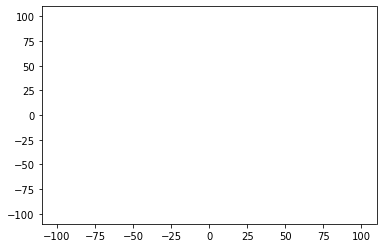

In [40]:
def get_shot_goal_hex_data(dictionary):

    # Get normalized data from previous function
    x_all_shots_normalized, y_all_shots_normalized, x_goal_normalized, y_goal_normalized = get_normalized_shots_goals(dictionary)

    # First we will used the hexbin function to simply bucket our shot data into basically a 2D histogram
    hex_data = plt.hexbin(x_all_shots_normalized,
                          y_all_shots_normalized,
                          gridsize = gridsize,
                          extent = extent,
                          mincnt = mincnt,
                          alpha = 0.0)

    # Now we extract the bin coordinates and counts
    verts = hex_data.get_offsets()
    shot_frequency = hex_data.get_array()

    # Do the same thing for the goal data
    goal_hex_data =  plt.hexbin(x_goal_normalized,
                                y_goal_normalized,
                                gridsize = gridsize,
                                extent = extent,
                                mincnt = mincnt,
                                alpha = 0.0)

    # Since the grid is the same we can use a shared bin coordinate set from the above. So here we just get the counts
    goal_frequency = goal_hex_data.get_array()

    return hex_data, goal_hex_data, verts, shot_frequency, goal_frequency

leauge_hex_data, league_goal_hex_data, league_verts, league_shot_frequency, league_goal_frequency = get_shot_goal_hex_data(league_data)
player_hex_data, player_goal_hex_data, player_verts, player_shot_frequency, player_goal_frequency = get_shot_goal_hex_data(player_data)

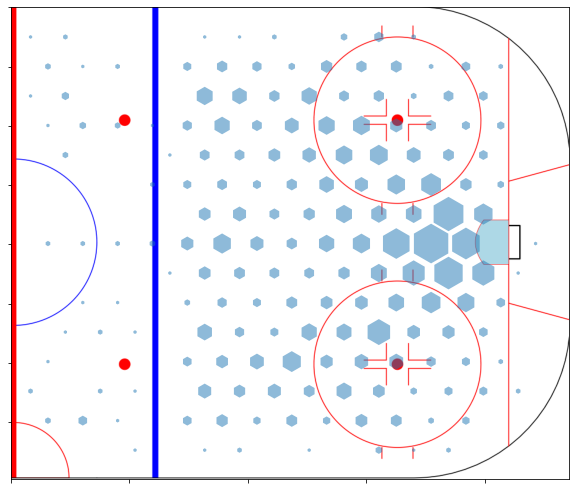

In [42]:
# League data

# Using matplotlib we create a new figure for plotting
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Clean up the figure to be completely blank
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
fig.patch.set_alpha(0.0)
# Remove the labelling of axes
ax.set_xticklabels(labels = [''], fontsize = 18,
   alpha = .7,minor=False)
ax.set_yticklabels(labels = [''], fontsize = 18,
   alpha = .7,minor=False)
# Using pillow to get the rink image and extract the image size
I = Image.open('nhl_arena.png')
ax.imshow(I);width, height = I.size


# Calculate the scaling factor and offset (trial and error)
scalingx=width/100-0.6
scalingy=height/100+0.5
x_trans=33
y_trans=height/2
# We will want to scale the size of our hex bins with the image so we calculate a "radius" scaling factor here
S = 3.8*scalingx


# Loop over the locations and draw the hex
for i,v in enumerate(league_verts):
   # Ignore empty locations
   if league_shot_frequency[i] < 1:continue
   
   # Normalize the shot frequency data between 0-1 
   scaled_league_shot_frequency = league_shot_frequency[i]/max(league_shot_frequency)
   # Scale the hexagon size based on shot frequency
   radius = S*math.sqrt(scaled_league_shot_frequency)
   # Finally we will plot the hexagon including the scaling and translations we found earlier
   hex = RegularPolygon((x_trans+v[0]*scalingx, 
      y_trans-v[1]*scalingy),numVertices=6, radius=radius,
      orientation=np.radians(0),alpha=0.5, edgecolor=None)
   ax.add_patch(hex)

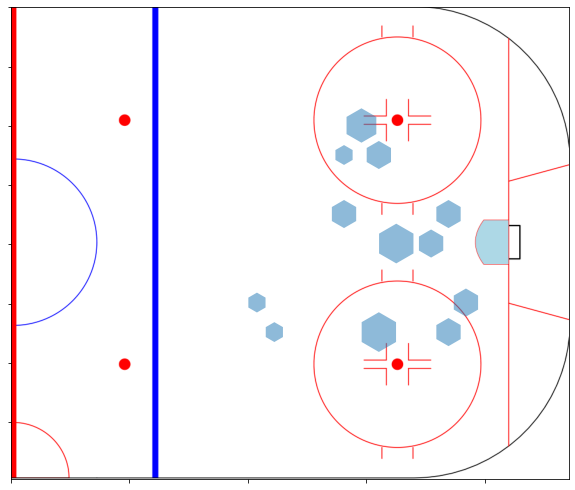

In [43]:
# Player data

# Using matplotlib we create a new figure for plotting
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Clean up the figure to be completely blank
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
fig.patch.set_alpha(0.0)
# Remove the labelling of axes
ax.set_xticklabels(labels = [''], fontsize = 18,
   alpha = .7,minor=False)
ax.set_yticklabels(labels = [''], fontsize = 18,
   alpha = .7,minor=False)
# Using pillow to get the rink image and extract the image size
I = Image.open('nhl_arena.png')
ax.imshow(I);width, height = I.size


# Calculate the scaling factor and offset (trial and error)
scalingx=width/100-0.6
scalingy=height/100+0.5
x_trans=33
y_trans=height/2
# We will want to scale the size of our hex bins with the image so we calculate a "radius" scaling factor here
S = 3.8*scalingx


# Loop over the locations and draw the hex
for i,v in enumerate(league_verts):
   # Ignore empty locations
   if player_shot_frequency[i] < 1:continue
   
   # Normalize the shot frequency data between 0-1 
   scaled_shot_frequency = player_shot_frequency[i]/max(player_shot_frequency)
   # Scale the hexagon size based on shot frequency
   radius = S*math.sqrt(scaled_shot_frequency)
   # Finally we will plot the hexagon including the scaling and translations we found earlier
   hex = RegularPolygon((x_trans+v[0]*scalingx, y_trans-v[1]*scalingy),
                        numVertices=6, 
                        radius=radius,
                        orientation=np.radians(0),
                        alpha=0.5, 
                        edgecolor=None)
   ax.add_patch(hex)

In [44]:
# Get some lists initialised 
league_efficiency = []
player_efficiency = []
relative_efficiency = []
# Looping over the league shots (which are the same in length as player)
for i in range(0,len(league_shot_frequency)):
    # We will only look at positions on the ice where the player orleague had more than two shots during the season
    if league_shot_frequency[i]<2 or player_shot_frequency[i]<2:
        continue
    
# Calculate the efficiencies 
league_efficiency.append(
   league_goal_frequency[i]/league_shot_frequency[i])
    
player_efficiency.append(
   player_goal_frequency[i]/player_shot_frequency[i])
    
# And the relative efficiency
relative_efficiency.append(
(player_goal_frequency[i]/player_shot_frequency[i]-
   (league_goal_frequency[i]/league_shot_frequency[i])))
# Keep track of the max so we can scale the colour and radius of the hex plot after
max_league_efficiency = max(league_efficiency)
max_player_efficiency = max(player_efficiency)
max_relative_efficiency = max(relative_efficiency)
min_relative_efficiency = min(relative_efficiency)

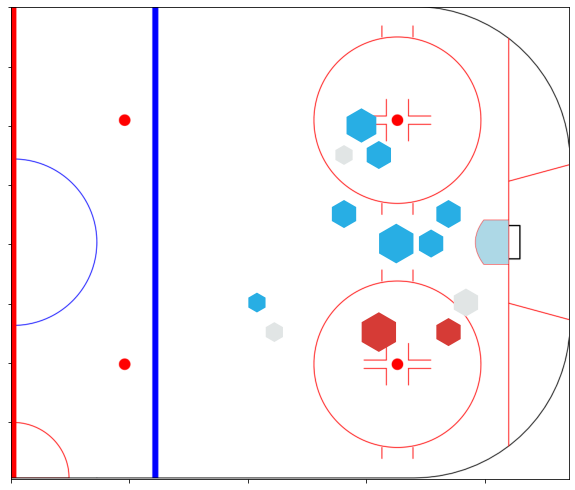

In [53]:
# Comparing player to league

# Using matplotlib we create a new figure for plotting
fig=plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# Clean up the figure to be completely blank
ax.set_facecolor("white")
fig.patch.set_facecolor("white")
fig.patch.set_alpha(0.0)
# Remove the labelling of axes
ax.set_xticklabels(labels = [''], fontsize = 18,
   alpha = .7,minor=False)
ax.set_yticklabels(labels = [''], fontsize = 18,
   alpha = .7,minor=False)
# Using pillow to get the rink image and extract the image size
I = Image.open('nhl_arena.png')
ax.imshow(I);width, height = I.size


# Calculate the scaling factor and offset (trial and error)
scalingx=width/100-0.6
scalingy=height/100+0.5
x_trans=33
y_trans=height/2
# We will want to scale the size of our hex bins with the image so we calculate a "radius" scaling factor here
S = 3.8*scalingx


# Loop over the locations and draw the hex
for i,v in enumerate(player_verts):
    # Here we will only include locations where the player made at least on shot.  We will adjust this later for plotting.
    if player_shot_frequency[i] < 1:continue
    
    # Scaling the frequencies
    scaled_player_shot_frequency = player_shot_frequency[i]/max(player_shot_frequency)
    # Calculate a radius of the hex
    radius = S*math.sqrt(scaled_player_shot_frequency)
   
    # Find the player efficiency and relative at this point on the ice.  
    player_efficiency = player_goal_frequency[i]/player_shot_frequency[i]
    league_efficiency = league_goal_frequency[i]/league_shot_frequency[i]
    # This is what we were after the whole time!   
    relative_efficiency = player_efficiency - league_efficiency
  
   # Since there can be positive and negative efficiencies (relative) we colour the more efficient locations red and the less blue.
    if relative_efficiency>0:
        colour = positive_cm(math.pow(relative_efficiency,0.1))
    else:
        colour = negative_cm(math.pow(-relative_efficiency,0.1))
   
   # And finally we plot!    
    hex = RegularPolygon((x_trans+v[0]*scalingx,y_trans-v[1]*scalingy),
                        numVertices=6, 
                        radius=radius,
                        orientation=np.radians(0),
                        facecolor=colour,
                        alpha=1,
                        edgecolor=None)
    ax.add_patch(hex)